In [ ]:
# train_model.py

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

df = pd.read_csv("/content/training_data.csv")
X = df.drop(columns=["match"])
y = df["match"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

joblib.dump(model, "job_match_model.pkl")
print("✅ Model trained and saved to job_match_model.pkl")


✅ Model trained and saved to job_match_model.pkl


In [ ]:

model = joblib.load("/content/job_match_model.pkl")

FEATURE_ORDER = [
    'is_verified', 'engagement_rate', 'num_socials', 'followers',
    'interest_travel', 'min_followers', 'platform_tiktok',
    'tag_fashion', 'content_type_story', 'interest_fashion',
    'platform_youtube', 'tag_beauty', 'content_type_reel',
    'interest_fitness', 'tag_travel', 'interest_tech',
    'platform_instagram', 'tag_gaming', 'content_type_video',
    'tag_tech', 'tag_fitness', 'interest_gaming', 'content_type_photo',
    'interest_beauty'
]

def predict(influencer, job):
    features = {key: 0 for key in FEATURE_ORDER}

    # Fill in numeric and boolean features
    features["is_verified"] = influencer.get("is_verified", 0)
    features["engagement_rate"] = influencer.get("engagement_rate", 0)
    features["num_socials"] = influencer.get("num_socials", 0)
    features["followers"] = influencer.get("followers", 0)
    features["min_followers"] = job.get("min_followers", 0)

    # Fill in categorical features
    interest_key = f"interest_{influencer.get('interest', '')}"
    platform_key = f"platform_{job.get('platform', '')}"
    tag_key = f"tag_{job.get('tag', '')}"
    content_type_key = f"content_type_{job.get('content_type', '')}"

    if interest_key in features:
        features[interest_key] = 1
    if platform_key in features:
        features[platform_key] = 1
    if tag_key in features:
        features[tag_key] = 1
    if content_type_key in features:
        features[content_type_key] = 1

    # Create DataFrame with proper column order
    df = pd.DataFrame([[features[key] for key in FEATURE_ORDER]], columns=FEATURE_ORDER)

    score = model.predict_proba(df)[0][1]
    return round(score, 2)

# Example usage
if __name__ == "__main__":
    influencer = {
        "is_verified": 1,
        "engagement_rate": 0.12,
        "num_socials": 3,
        "followers": 12000,
        "interest": "tech"
    }

    job = {
        "min_followers": 5000,
        "platform": "instagram",
        "tag": "tech",
        "content_type": "story"
    }

    print("🔮 Match score:", predict(influencer, job))


🔮 Match score: 0.14


In [ ]:

from sklearn.metrics import classification_report, roc_auc_score

# Load your trained model
model = joblib.load("/content/job_match_model.pkl")

# Feature order from your trained model
FEATURE_ORDER = [
    'is_verified', 'engagement_rate', 'num_socials', 'followers',
    'interest_travel', 'min_followers', 'platform_tiktok',
    'tag_fashion', 'content_type_story', 'interest_fashion',
    'platform_youtube', 'tag_beauty', 'content_type_reel',
    'interest_fitness', 'tag_travel', 'interest_tech',
    'platform_instagram', 'tag_gaming', 'content_type_video',
    'tag_tech', 'tag_fitness', 'interest_gaming', 'content_type_photo',
    'interest_beauty'
]

def create_feature_vector(influencer, job):
    features = {key: 0 for key in FEATURE_ORDER}

    # Numeric / boolean features
    features["is_verified"] = influencer.get("is_verified", 0)
    features["engagement_rate"] = influencer.get("engagement_rate", 0)
    features["num_socials"] = influencer.get("num_socials", 0)
    features["followers"] = influencer.get("followers", 0)
    features["min_followers"] = job.get("min_followers", 0)

    # Categorical one-hot encoded features
    interest_key = f"interest_{influencer.get('interest', '')}"
    platform_key = f"platform_{job.get('platform', '')}"
    tag_key = f"tag_{job.get('tag', '')}"
    content_type_key = f"content_type_{job.get('content_type', '')}"

    if interest_key in features:
        features[interest_key] = 1
    if platform_key in features:
        features[platform_key] = 1
    if tag_key in features:
        features[tag_key] = 1
    if content_type_key in features:
        features[content_type_key] = 1

    return [features[key] for key in FEATURE_ORDER]

# === Generate Fake Test Data ===
# For a real project, replace this with your labeled test set!

def generate_fake_test_data(n=100):
    np.random.seed(42)
    influencers = []
    jobs = []
    labels = []

    possible_interests = ["travel", "fashion", "fitness", "tech", "gaming", "beauty"]
    possible_platforms = ["tiktok", "youtube", "instagram"]
    possible_tags = ["fashion", "beauty", "travel", "tech", "gaming", "fitness"]
    possible_content_types = ["story", "reel", "video", "photo"]

    for _ in range(n):
        influencer = {
            "is_verified": np.random.choice([0, 1]),
            "engagement_rate": np.random.uniform(0, 0.2),
            "num_socials": np.random.randint(1, 5),
            "followers": np.random.randint(1000, 50000),
            "interest": np.random.choice(possible_interests),
        }
        job = {
            "min_followers": np.random.randint(500, 20000),
            "platform": np.random.choice(possible_platforms),
            "tag": np.random.choice(possible_tags),
            "content_type": np.random.choice(possible_content_types),
        }

        # Simple labeling logic for fake ground truth (for demo only):
        # If influencer's followers > job's min_followers and interest matches tag, label=1 else 0
        label = int((influencer["followers"] >= job["min_followers"]) and
                    (influencer["interest"] == job["tag"]))

        influencers.append(influencer)
        jobs.append(job)
        labels.append(label)

    return influencers, jobs, labels


if __name__ == "__main__":
    influencers, jobs, y_true = generate_fake_test_data(n=200)

    # Convert to feature vectors
    X_test = [create_feature_vector(influ, job) for influ, job in zip(influencers, jobs)]
    X_test = pd.DataFrame(X_test, columns=FEATURE_ORDER)

    # Predict probabilities
    y_scores = model.predict_proba(X_test)[:, 1]

    # Default threshold 0.5
    y_pred = (y_scores >= 0.5).astype(int)

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred))

    # Print ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC Score: {roc_auc:.3f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       173
           1       0.00      0.00      0.00        27

    accuracy                           0.86       200
   macro avg       0.43      0.50      0.46       200
weighted avg       0.75      0.86      0.80       200

ROC AUC Score: 0.997


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
threshold = 0.2  # Lower than 0.5 to catch more positives
y_pred = (y_scores >= threshold).astype(int)


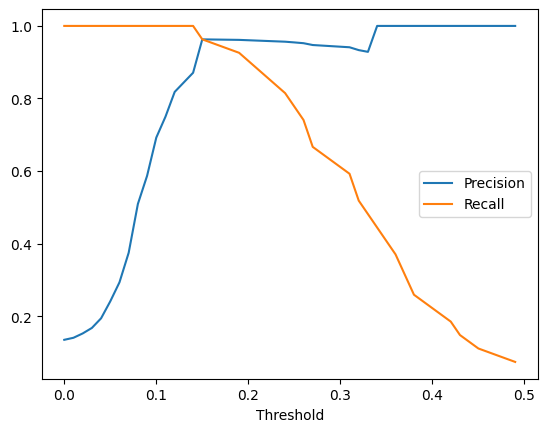

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()


In [ ]:
threshold = 0.2
y_pred = (y_scores >= threshold).astype(int)
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       173
           1       0.96      0.81      0.88        27

    accuracy                           0.97       200
   macro avg       0.96      0.90      0.93       200
weighted avg       0.97      0.97      0.97       200



In [ ]:

joblib.dump(model, "job_match_model_LAST.pkl")


['job_match_model_LAST.pkl']

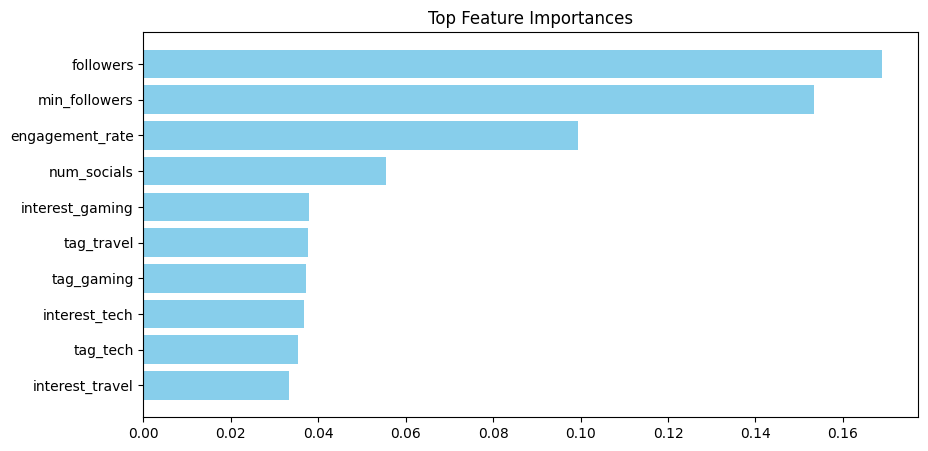

In [ ]:
def plot_feature_importance(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, 5))
    plt.title("Top Feature Importances")
    plt.barh(range(top_n), importances[indices], color="skyblue", align="center")
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.show()

# Call it:
plot_feature_importance(model, ALL_FEATURES)


In [ ]:
def plot_class_distribution(y):
    labels = ['Not Match (0)', 'Match (1)']
    counts = [sum(y==0), sum(y==1)]

    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title("Class Distribution in Training Data")
    plt.show()


In [ ]:
def predict(influencer, job):
    # Build the features dict with string keys
    features = {
        "is_verified": influencer["is_verified"],
        "engagement_rate": influencer["engagement_rate"],
        "num_socials": influencer["num_socials"],
        "followers": influencer["followers"],
        f"interest_{influencer['interest']}": 1,
        "min_followers": job["min_followers"],
        f"platform_{job['platform']}": 1,
        f"tag_{job['tag']}": 1,
        f"content_type_{job['content_type']}": 1,
    }

    # Fill missing features with 0, ensuring keys are strings
    for name in feature_names:
        if name not in features:
            features[name] = 0

    # Create DataFrame with string column names
    df = pd.DataFrame([features])
    df.columns = df.columns.astype(str)  # explicitly convert all column names to strings

    # Predict probability
    score = model.predict_proba(df)[0][1]
    return round(score, 2)


In [ ]:
feature_names = [
    'is_verified', 'engagement_rate', 'num_socials', 'followers',
    'interest_travel', 'min_followers', 'platform_tiktok', 'tag_fashion', 'content_type_story',
    'interest_fashion', 'platform_youtube', 'tag_beauty', 'content_type_reel',
    'interest_fitness', 'tag_travel', 'interest_tech', 'platform_instagram',
    'tag_gaming', 'content_type_video', 'tag_tech', 'tag_fitness', 'interest_gaming',
    'content_type_photo', 'interest_beauty'
]


In [ ]:
import joblib
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']

In [ ]:
feature_names = joblib.load("feature_names.pkl")


In [ ]:
def predict(influencer, job):
    features = {
        "is_verified": influencer["is_verified"],
        "engagement_rate": influencer["engagement_rate"],
        "num_socials": influencer["num_socials"],
        "followers": influencer["followers"],
        f"interest_{influencer['interest']}": 1,
        "min_followers": job["min_followers"],
        f"platform_{job['platform']}": 1,
        f"tag_{job['tag']}": 1,
        f"content_type_{job['content_type']}": 1,
    }

    # Fill missing features with 0
    for feat in feature_names:
        if feat not in features:
            features[feat] = 0

    df = pd.DataFrame([features])
    df.columns = df.columns.astype(str)

    score = model.predict_proba(df)[0][1]
    return round(score, 2)



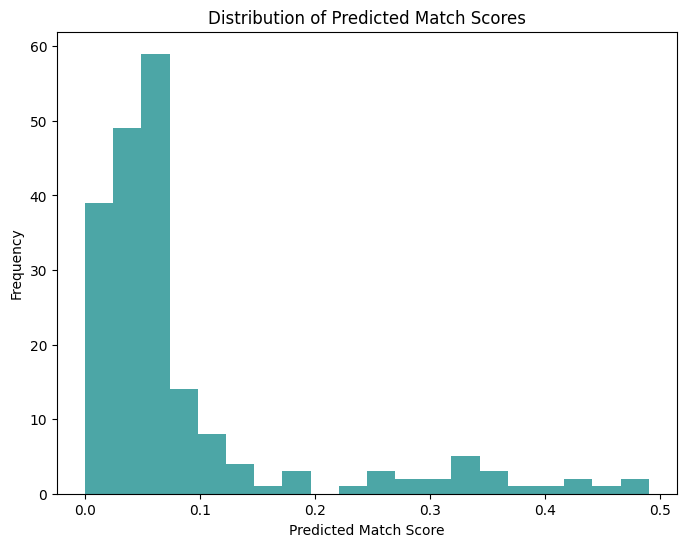

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(y_scores, bins=20, color='teal', alpha=0.7)
plt.xlabel("Predicted Match Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Match Scores")
plt.show()


In [ ]:
import pandas as pd

sample_matches = [
    {"influencer": "Alice", "job_title": "Tech Review Campaign", "score": 0.95},
    {"influencer": "Bob", "job_title": "Fashion Shoot", "score": 0.89},
    {"influencer": "Carol", "job_title": "Fitness Brand Promo", "score": 0.87},
]

df = pd.DataFrame(sample_matches)
df.style.background_gradient(cmap='Greens')


,influencer,job_title,score
0,Alice,Tech Review Campaign,0.950000
1,Bob,Fashion Shoot,0.890000
2,Carol,Fitness Brand Promo,0.870000
